In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.linear_model import LinearRegression, PoissonRegressor

In [3]:
np.random.seed(42)

In [62]:
df_calendar.head()

,date,wm_yr_wk,weekday,week_of_year,month,year,d,event_name,event,snap_CA,snap_TX,snap_WI
337,2012-01-01,11149,Sunday,52,1,2012,d_338,NewYear,1,1,1,0
338,2012-01-02,11149,Monday,1,1,2012,d_339,No Event,0,1,0,1
339,2012-01-03,11149,Tuesday,1,1,2012,d_340,No Event,0,1,1,1
340,2012-01-04,11149,Wednesday,1,1,2012,d_341,No Event,0,1,0,0
341,2012-01-05,11149,Thursday,1,1,2012,d_342,No Event,0,1,1,1


In [4]:
df_calendar = pd.read_csv("../data/calendar.csv", parse_dates=["date"])
df_wide_train_val = pd.read_csv("../data/sales_train_validation.csv")
df_prices = pd.read_csv("../data/sell_prices.csv")

In [5]:
df_calendar.insert(3, "week_of_year", df_calendar['date'].dt.isocalendar().week)
df_calendar['event_name'] = df_calendar['event_name_1'].apply(lambda s: s if isinstance(s, str) else "No Event")
df_calendar['event'] = df_calendar['event_name'].apply(lambda el: 1 if el != "No Event" else 0)
df_calendar = df_calendar[['date', 'wm_yr_wk', 'weekday', 'week_of_year', 'month', 'year', 'd', 'event_name', 'event', "snap_CA",	"snap_TX",	"snap_WI"]]
# create a mapping from d_i days to date
day2date = df_calendar.set_index('d')['date'].to_dict()
df_calendar

,date,wm_yr_wk,weekday,week_of_year,month,year,d,event_name,event,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,4,1,2011,d_1,No Event,0,0,0,0
1,2011-01-30,11101,Sunday,4,1,2011,d_2,No Event,0,0,0,0
2,2011-01-31,11101,Monday,5,1,2011,d_3,No Event,0,0,0,0
3,2011-02-01,11101,Tuesday,5,2,2011,d_4,No Event,0,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,No Event,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,24,6,2016,d_1965,No Event,0,0,1,1
1965,2016-06-16,11620,Thursday,24,6,2016,d_1966,No Event,0,0,0,0
1966,2016-06-17,11620,Friday,24,6,2016,d_1967,No Event,0,0,0,0
1967,2016-06-18,11621,Saturday,24,6,2016,d_1968,No Event,0,0,0,0


In [6]:
n_items = 100
items = np.random.choice(df_wide_train_val.query("dept_id == 'FOODS_3'")["item_id"].unique(), size=n_items, replace=False)
# items

In [7]:
df_wide_train_val = df_wide_train_val.query("dept_id == 'FOODS_3' and item_id.isin(@items)")
df_wide_train_val = df_wide_train_val.drop(columns=["id", "dept_id", "cat_id"], axis=1)
# df_train_val = df_train_val.set_index(keys=["state_id", "store_id", "item_id"])

In [8]:
start_date = pd.Timestamp("2012-01-01")
end_date = pd.Timestamp("2016-01-31")

In [9]:
df_train_val = pd.wide_to_long(df_wide_train_val, stubnames='d_', i=["item_id", "store_id", "state_id"], j='date')
df_train_val = (
    df_train_val
    .reset_index(level="date")
    .reorder_levels(order=["state_id", "store_id", "item_id"])
    .rename(columns={"d_": "sales"})
)
df_train_val["date"] = df_train_val["date"].map(lambda el: day2date[f"d_{el}"])

df_train_val = df_train_val.loc[df_train_val['date'].between(start_date, end_date)].copy()
df_train_val = df_train_val.set_index("date", append=True)

In [10]:
df_train_val

sales
state_id store_id item_id     date             
CA       CA_1     FOODS_3_024 2012-01-01      0
                              2012-01-02      0
                              2012-01-03      0
                              2012-01-04      0
                              2012-01-05      0
...                                         ...
WI       WI_3     FOODS_3_826 2016-01-27      0
                              2016-01-28      2
                              2016-01-29      0
                              2016-01-30      1
                              2016-01-31      3

[1492000 rows x 1 columns]

In [11]:
df_calendar
df_calendar = df_calendar.loc[df_calendar['date'].between(start_date, end_date)].copy()

In [12]:
df_prices = df_prices.query("item_id.str.startswith('FOODS_3') and item_id in @items")

In [13]:
price_df = (
    pd.merge(df_prices, df_calendar.reset_index()[["wm_yr_wk", "date"]], on="wm_yr_wk")
    .set_index(["store_id", "item_id", "date"])
    .drop(columns="wm_yr_wk")
    .sort_index()
)
price_df

sell_price
store_id item_id     date                  
CA_1     FOODS_3_024 2014-03-01        0.98
                     2014-03-02        0.98
                     2014-03-03        0.98
                     2014-03-04        0.98
                     2014-03-05        0.98
...                                     ...
WI_3     FOODS_3_826 2016-01-27        1.28
                     2016-01-28        1.28
                     2016-01-29        1.28
                     2016-01-30        1.28
                     2016-01-31        1.28

[1247379 rows x 1 columns]

In [14]:
df_cal = (
    pd.wide_to_long(
        df_calendar.drop(columns=["d"]), 
        stubnames='snap_',
        i=["date"],
        j='state_id',
        suffix="\\D+"
    )
    .reorder_levels(order=["state_id", "date"])  # reorder index level
    .rename(columns={"snap_": "snap"}))
df_cal

event event_name  month  week_of_year    weekday  \
state_id date                                                           
CA       2012-01-01      1    NewYear      1            52     Sunday   
         2012-01-02      0   No Event      1             1     Monday   
         2012-01-03      0   No Event      1             1    Tuesday   
         2012-01-04      0   No Event      1             1  Wednesday   
         2012-01-05      0   No Event      1             1   Thursday   
...                    ...        ...    ...           ...        ...   
WI       2016-01-27      0   No Event      1             4  Wednesday   
         2016-01-28      0   No Event      1             4   Thursday   
         2016-01-29      0   No Event      1             4     Friday   
         2016-01-30      0   No Event      1             4   Saturday   
         2016-01-31      0   No Event      1             4     Sunday   

                     wm_yr_wk  year  snap  
state_id date                              
CA       2012-01-01     11149  2012     1  
         2012-01-02     11149  2012     1  
         2012-01-03     11149  2012     1  
         2012-01-04     11149  2012     1  
         2012-01-05     11149  2012     1  
...                       ...   ...   ...  
WI       2016-01-27     11552  2016     0  
         2016-01-28     11552  2016     0  
         2016-01-29     11552  2016     0  
         2016-01-30     11601  2016     0  
         2016-01-31     11601  2016     0  

[4476 rows x 8 columns]

In [15]:
X_price = (
    df_train_val
    .merge(price_df, on=["store_id", "item_id", "date"], how="left")
    .drop(columns="sales")
    .fillna(value=0.0)
    .set_index(df_train_val.index)
)

In [16]:
cols = ["weekday", "month", "year", "event_name", "sell_price"]
X = (
    X_price
    .merge(df_cal, on=["state_id", "date"])
    .set_index(X_price.index)
)
X = X[cols]
X

weekday  month  year event_name  \
state_id store_id item_id     date                                            
CA       CA_1     FOODS_3_024 2012-01-01     Sunday      1  2012    NewYear   
                              2012-01-02     Monday      1  2012   No Event   
                              2012-01-03    Tuesday      1  2012   No Event   
                              2012-01-04  Wednesday      1  2012   No Event   
                              2012-01-05   Thursday      1  2012   No Event   
...                                             ...    ...   ...        ...   
WI       WI_3     FOODS_3_826 2016-01-27  Wednesday      1  2016   No Event   
                              2016-01-28   Thursday      1  2016   No Event   
                              2016-01-29     Friday      1  2016   No Event   
                              2016-01-30   Saturday      1  2016   No Event   
                              2016-01-31     Sunday      1  2016   No Event   

                                          sell_price  
state_id store_id item_id     date                    
CA       CA_1     FOODS_3_024 2012-01-01        0.00  
                              2012-01-02        0.00  
                              2012-01-03        0.00  
                              2012-01-04        0.00  
                              2012-01-05        0.00  
...                                              ...  
WI       WI_3     FOODS_3_826 2016-01-27        1.28  
                              2016-01-28        1.28  
                              2016-01-29        1.28  
                              2016-01-30        1.28  
                              2016-01-31        1.28  

[1492000 rows x 5 columns]

In [17]:
y = df_train_val[['sales']]

# Train-Test Split
* expanding window

In [18]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.split import ExpandingWindowSplitter

In [19]:
from sktime.utils import plot_series, plot_windows

In [20]:
from sktime.transformations.compose import Id, FeatureUnion, TransformerPipeline, ColumnEnsembleTransformer
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import OneHotEncoder

In [21]:
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=31)

In [22]:
cv = ExpandingWindowSplitter(
    fh=np.arange(1, 31), initial_window=int(365 * 2), step_length=30
)

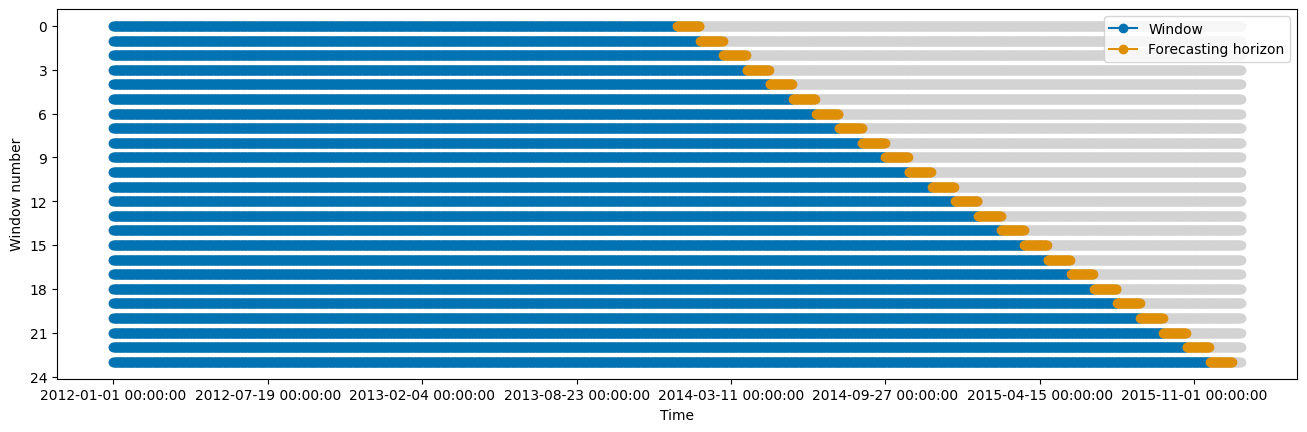

In [23]:
plot_windows(
    cv=cv,
    y=y_train.xs(("CA_1", "FOODS_3_024"), level=("store_id", "item_id")).reset_index(level="state_id", drop=True)
)
plt.show()

# Models
* Regression- Linear + Poisson
* Naive forecaster- last period/season

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin
# from sktime.forecasting.compose import RecursiveTabularRegressionForecaster, ForecastingPipeline, make_reduction
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from typing import Optional

In [32]:
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError,
    MeanSquaredError
)
from sktime.forecasting.model_evaluation import evaluate

In [25]:
class OHEwithBaseline(OneHotEncoder):

    def __init__(self, baseline_category: str, drop_first: bool=False):
        self.baseline_category = baseline_category
        self.drop_first = drop_first
        self.ohe = OneHotEncoder(drop='first' if self.drop_first else None, sparse_output=False)

    def fit(self, X: np.ndarray | pd.DataFrame, y: Optional[pd.Series]=None):
        self.ohe.fit(X)
        categories_ = self.ohe.categories_[0].tolist()
        categories_.remove(self.baseline_category)
        categories_.insert(0,self.baseline_category)
        self.ohe.categories_[0] = np.array(categories_)
        return self

    def transform(self, X: np.ndarray | pd.DataFrame, y: Optional[pd.Series]=None) -> pd.DataFrame:
        X = self.ohe.transform(X)
        return X

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_transform = self.ohe.inverse_transform(X)
        return X_transform

    def get_feature_names_out(self, *args, **params):
        return self.ohe.get_feature_names_out()

In [26]:
# weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# months = list(range(1, 13))
# years = [2012, 2013, 2014, 2015, 2016]
# events = [
#     'No Event', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'SuperBowl', 'ValentinesDay',
#     'PresidentsDay', 'LentStart', 'LentWeek2', 'Purim End', 'StPatricksDay', 'Easter', 'Pesach End',
#     'OrthodoxEaster', 'Cinco De Mayo', "Mother's day", 'MemorialDay', 'NBAFinalsStart', "Father's day",
#     'NBAFinalsEnd', 'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 
#     'EidAlAdha', 'Halloween', 'VeteransDay', 'Thanksgiving', 'Chanukah End', 'Christmas'
# ]

In [27]:
column_transformer = ColumnEnsembleTransformer(
    transformers=[
        (
            "ohe_week",
            TabularToSeriesAdaptor(OHEwithBaseline(baseline_category="Monday", drop_first=True).set_output(transform="pandas"), input_type="pandas"),
            ["weekday"]
        ),
        (
            "ohe_month",
            TabularToSeriesAdaptor(OHEwithBaseline(baseline_category=1, drop_first=True).set_output(transform="pandas"), input_type="pandas"),
            ["month"]
        ),
        (
            "ohe_year",
            TabularToSeriesAdaptor(OHEwithBaseline(baseline_category=2012, drop_first=True).set_output(transform="pandas"), input_type="pandas"),
            ["year"]
        ),
        (
            "ohe_event",
            TabularToSeriesAdaptor(OHEwithBaseline(baseline_category='No Event', drop_first=True).set_output(transform="pandas"), input_type="pandas"),
            ["event_name"]
        )
    ],
    remainder="passthrough",
    feature_names_out="original"
)

In [28]:
# tmp = column_transformer.fit_transform(X_train)

In [29]:
# tmp.head()

In [30]:
# local models
lr_local_pipe = column_transformer ** make_reduction(estimator=LinearRegression(), window_length=7, strategy='recursive', pooling="local")
pois_local_pipe = column_transformer ** make_reduction(estimator=PoissonRegressor(), window_length=7, strategy='recursive', pooling="local")
# global models
lr_global_pipe = column_transformer ** make_reduction(estimator=LinearRegression(), window_length=7, strategy='recursive', pooling="global")
pois_global_pipe = column_transformer ** make_reduction(estimator=PoissonRegressor(), window_length=7, strategy='recursive', pooling="global")

# baseline- naive (weekly seasonal, last prediction)
nc_model = NaiveForecaster(sp=1)
# naive seasonal model with weekly seasonality 7
ns_model = NaiveForecaster(sp=7)

In [33]:
X_train.shape, y_train.shape

((1461000, 5), (1461000, 1))

In [34]:
mae = MeanAbsoluteError()
rmse = MeanSquaredError(square_root=True)

scoring = [mae, rmse]

In [35]:
lr_local_results = evaluate(lr_local_pipe, cv=cv, y=y_train, X=X_train, scoring=scoring, return_model=False)
lr_local_results

/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sktime/utils/parallel.py:107: FitFailedWarning: 
                In evaluate, fitting of forecaster ForecastingPipeline failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=730000.
                The score will be set to nan.
                Failed forecaster with parameters: ForecastingPipeline(steps=[ColumnEnsembleTransformer(feature_names_out='original',
                                                     remainder='passthrough',
                                                     transformers=[('ohe_week',
                                                                    TabularToSeriesAdaptor(input_type='pandas',
                                                                                           trans

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,43.871493,NaN,730,NaN
1,3.271802e+00,5.423288e+00,44.830255,14.842404,760,2014-01-29 00:00:00
2,8.895928e+05,3.254717e+06,45.490389,15.291982,790,2014-02-28 00:00:00
3,1.803222e+00,2.372214e+00,46.094449,15.023165,820,2014-03-30 00:00:00
4,2.598252e+01,5.809461e+01,47.351540,15.058841,850,2014-04-29 00:00:00
5,1.776391e+00,2.283970e+00,47.923485,15.127131,880,2014-05-29 00:00:00
6,7.595537e+10,3.008911e+11,48.130557,15.308226,910,2014-06-28 00:00:00
7,1.643673e+00,2.124959e+00,48.302610,15.493949,940,2014-07-28 00:00:00
8,1.702575e+00,2.240005e+00,50.580936,16.126243,970,2014-08-27 00:00:00
9,1.734434e+00,2.252836e+00,50.273411,15.750847,1000,2014-09-26 00:00:00


1.546383

In [36]:
lr_global_results = evaluate(lr_global_pipe, cv=cv, y=y_train, X=X_train, scoring=scoring, return_model=False)
lr_global_results

/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sktime/utils/parallel.py:107: FitFailedWarning: 
                In evaluate, fitting of forecaster ForecastingPipeline failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=730000.
                The score will be set to nan.
                Failed forecaster with parameters: ForecastingPipeline(steps=[ColumnEnsembleTransformer(feature_names_out='original',
                                                     remainder='passthrough',
                                                     transformers=[('ohe_week',
                                                                    TabularToSeriesAdaptor(input_type='pandas',
                                                                                           trans

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,22.806682,NaN,730,NaN
1,1.475682,1.887542,22.985174,139.949440,760,2014-01-29 00:00:00
2,1.537281,1.989468,23.032324,140.486487,790,2014-02-28 00:00:00
3,1.493332,1.944310,23.439871,140.645117,820,2014-03-30 00:00:00
4,1.706817,2.126692,23.710041,140.653768,850,2014-04-29 00:00:00
5,1.678253,2.127424,24.056210,140.827994,880,2014-05-29 00:00:00
6,1.624237,2.083360,24.334588,141.192667,910,2014-06-28 00:00:00
7,1.577213,2.038389,24.604651,140.842327,940,2014-07-28 00:00:00
8,1.558030,1.969465,24.841734,141.365455,970,2014-08-27 00:00:00
9,1.626064,2.043547,25.131868,141.257982,1000,2014-09-26 00:00:00


In [37]:
pois_local_results = evaluate(pois_local_pipe, cv=cv, y=y_train, X=X_train, scoring=scoring, return_model=False)
pois_local_results

/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sklearn/_loss/link.py:175: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sklearn/_loss/link.py:175: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sklearn/_loss/link.py:175: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sklearn/_loss/link.py:175: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sklearn/_loss/link.py:175: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/galkampel/Desktop/Proje

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,32.929568,NaN,730,NaN
1,NaN,NaN,35.569762,NaN,760,NaN
2,NaN,NaN,35.530785,NaN,790,NaN
3,NaN,NaN,34.897957,NaN,820,NaN
4,NaN,NaN,35.381620,NaN,850,NaN
5,NaN,NaN,36.067691,NaN,880,NaN
6,NaN,NaN,37.212110,NaN,910,NaN
7,NaN,NaN,38.306055,NaN,940,NaN
8,NaN,NaN,38.702229,NaN,970,NaN
9,NaN,NaN,38.194678,NaN,1000,NaN


In [38]:
pois_global_results = evaluate(pois_global_pipe, cv=cv, y=y_train, X=X_train, scoring=scoring, return_model=False)
pois_global_results

/Users/galkampel/Desktop/Projects/m5_forecasting/.venv/lib/python3.12/site-packages/sktime/utils/parallel.py:107: FitFailedWarning: 
                In evaluate, fitting of forecaster ForecastingPipeline failed,
                you can set error_score='raise' in evaluate to see
                the exception message.
                Fit failed for the 0-th data split, on training data y_train with
                cutoff <NA>, and len(y_train)=730000.
                The score will be set to nan.
                Failed forecaster with parameters: ForecastingPipeline(steps=[ColumnEnsembleTransformer(feature_names_out='original',
                                                     remainder='passthrough',
                                                     transformers=[('ohe_week',
                                                                    TabularToSeriesAdaptor(input_type='pandas',
                                                                                           trans

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,NaN,NaN,24.402541,NaN,730,NaN
1,2.281031,2.645574,25.003658,141.519558,760,2014-01-29 00:00:00
2,2.447347,2.852462,25.208046,141.861691,790,2014-02-28 00:00:00
3,2.517893,2.918008,25.907901,141.211274,820,2014-03-30 00:00:00
4,2.471392,2.906241,25.846814,141.253192,850,2014-04-29 00:00:00
5,2.541509,2.945878,26.330124,141.825634,880,2014-05-29 00:00:00
6,2.682559,3.081862,26.196459,141.829756,910,2014-06-28 00:00:00
7,2.769501,3.179378,27.046348,144.508199,940,2014-07-28 00:00:00
8,NaN,NaN,28.409987,NaN,970,NaN
9,2.479271,2.876519,27.612527,143.137184,1000,2014-09-26 00:00:00


In [39]:
nc_results = evaluate(nc_model, cv=cv, y=y_train, scoring=scoring, return_model=False)
nc_results

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,1.692900,2.184756,2.580986,4.493987,730,2013-12-30 00:00:00
1,1.540467,2.059303,2.570487,4.515777,760,2014-01-29 00:00:00
2,1.647633,2.171960,2.640675,4.521062,790,2014-02-28 00:00:00
3,1.904533,2.405596,2.693091,4.521309,820,2014-03-30 00:00:00
4,1.746567,2.292297,2.721519,4.513414,850,2014-04-29 00:00:00
5,1.676167,2.242999,2.738296,4.546403,880,2014-05-29 00:00:00
6,1.824000,2.336745,2.770695,4.562192,910,2014-06-28 00:00:00
7,1.677833,2.232439,2.775731,4.560935,940,2014-07-28 00:00:00
8,1.699133,2.253092,2.799340,4.574911,970,2014-08-27 00:00:00
9,1.727867,2.224824,2.834378,4.601806,1000,2014-09-26 00:00:00


In [40]:
ns_results = evaluate(ns_model, cv=cv, y=y_train, scoring=scoring, return_model=False)
ns_results

,test_MeanAbsoluteError,test_MeanSquaredError,fit_time,pred_time,len_train_window,cutoff
0,1.647200,2.308908,2.591278,9.028470,730,2013-12-30 00:00:00
1,1.554067,2.124016,2.587502,9.078390,760,2014-01-29 00:00:00
2,1.568800,2.154838,2.649613,9.190275,790,2014-02-28 00:00:00
3,1.641500,2.236361,2.676637,9.175372,820,2014-03-30 00:00:00
4,1.790567,2.407886,2.682902,9.273264,850,2014-04-29 00:00:00
5,1.668900,2.289935,2.785291,9.364690,880,2014-05-29 00:00:00
6,1.749333,2.383958,2.797547,9.328405,910,2014-06-28 00:00:00
7,1.701433,2.332170,2.815481,9.322460,940,2014-07-28 00:00:00
8,1.773833,2.392350,2.858576,9.397130,970,2014-08-27 00:00:00
9,1.774600,2.369799,2.865055,9.433396,1000,2014-09-26 00:00:00


In [58]:
import os
from pathlib import Path

PosixPath('/Users/galkampel/Desktop/Projects/m5_forecasting/outputs')

In [ ]:
os.makedirs(Path(os.getcwd()).parent.joinpath("outputs"), exist_ok=True)

In [ ]:
output_dir = Path(os.getcwd()).parent.joinpath("outputs")
output_dir

In [60]:
results_dict = {
    "lr_local": lr_local_results,
    "lr_global": lr_global_results,
    "poisson_local": pois_local_results,
    "poisson_global": pois_global_results,
    "naive_pred": nc_results,
    "naive_seasonal": ns_results
}

In [61]:
for filename, df_result in results_dict.items():
    df_result.to_csv(output_dir.joinpath(f"{filename}.csv"), index=False)

In [59]:
# ns_results.to_csv(output_dir.joinpath("naive_seasonal.csv"), index=False)